In [16]:
%load_ext autoreload
%autoreload 2

import torchvision
import torch

import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from itertools import islice

import training
from models import *

from torch.utils.tensorboard import SummaryWriter

from utils import plot_history


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)
data_path = "../data/"


cuda:0


# MNIST classifiers

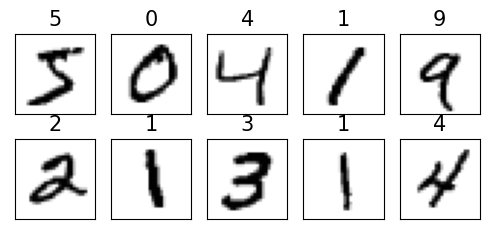

In [9]:
mnist_dataset = torchvision.datasets.MNIST(
    data_path, train=True, download=True)

fig = plt.figure(figsize=(6, 2.5))

for i, (image, label) in islice(enumerate(mnist_dataset), 10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(image, cmap='gray_r')
    ax.set_title(f'{label}', size=15)


In [10]:
batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor(),
    # torchvision.transforms.Normalize((0.1307,), (0.3081,)),
])

_test = torchvision.datasets.MNIST(
    data_path, train=False, download=False, transform=transform
)

_train = torchvision.datasets.MNIST(
    data_path, train=True, download=False, transform=transform
)
_train.data = _train.data[:50000]
_train.targets = _train.targets[:50000]

_valid = torchvision.datasets.MNIST(
    data_path, train=True, download=False, transform=transform
)
_valid.data = _valid.data[50000:]
_valid.targets = _valid.targets[50000:]


train_loader = DataLoader(_train, batch_size=batch_size, shuffle=True, num_workers=16)
val_loader = DataLoader(_valid, batch_size=batch_size, shuffle=False, num_workers=16)
test_loader = DataLoader(_test, batch_size=batch_size, shuffle=False, num_workers=16)

print(
    f"Samples\nTrain: {len(_train)}\nValid: {len(_valid)}\nTest:  {len(_test)}")


Samples
Train: 50000
Valid: 10000
Test:  10000


## Fully conected neural newtork (no convolution)

In [11]:
model = FlattenModel(nn.Linear(28*28, 512),
                     nn.ReLU(),
                     nn.Linear(512, 256),
                     nn.ReLU(),
                     nn.Linear(256, 128),
                     nn.ReLU(),
                     nn.Linear(128, 10),
                    )

model = model.to(device)

model

FlattenModel(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [12]:
writer = SummaryWriter("./run/mnist1")
examples = iter(test_loader)
example_data, example_targets = next(examples)
writer.add_graph(model, example_data.to(device))

In [13]:
training.test_model(test_loader, model)

Test Error: Accuracy: 10.09%, Avg loss: 0.018188


In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
history = training.train_loop(train_loader, model, optimizer=optimizer, val_dataloader=val_loader, num_epochs=15, verbose=True)

Epoch 1/15
Train loss: 0.343881, accuracy: 89.84%
Validation loss:  0.001060, accuracy: 96.21%
-----------------------------
Epoch 2/15
Train loss: 0.119502, accuracy: 96.32%
Validation loss:  0.000892, accuracy: 96.69%
-----------------------------
Epoch 3/15
Train loss: 0.076078, accuracy: 97.60%
Validation loss:  0.000693, accuracy: 97.39%
-----------------------------
Epoch 4/15
Train loss: 0.050893, accuracy: 98.44%
Validation loss:  0.000699, accuracy: 97.35%
-----------------------------
Epoch 5/15
Train loss: 0.044412, accuracy: 98.60%
Validation loss:  0.000618, accuracy: 97.76%
-----------------------------
Epoch 6/15
Train loss: 0.031673, accuracy: 98.98%
Validation loss:  0.000680, accuracy: 97.59%
-----------------------------
Epoch 7/15
Train loss: 0.025456, accuracy: 99.16%
Validation loss:  0.000669, accuracy: 97.93%
-----------------------------
Epoch 8/15
Train loss: 0.019136, accuracy: 99.43%
Validation loss:  0.000722, accuracy: 97.68%
-----------------------------


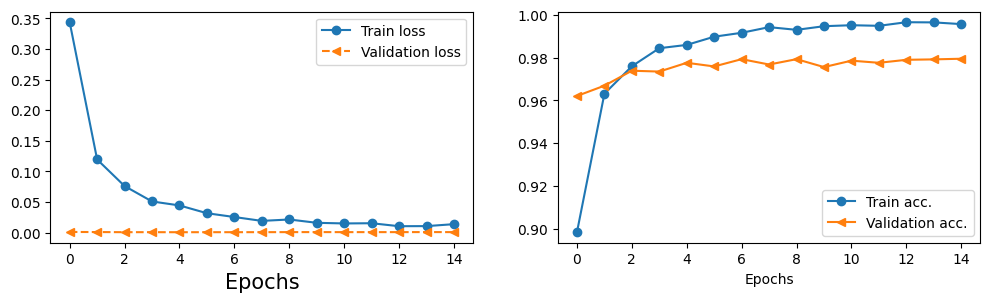

In [23]:
plot_history(history)

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
history = training.train_loop(train_loader, model, optimizer=optimizer, val_dataloader=val_loader, num_epochs=15, verbose=True, writer=writer)
writer.close()

Epoch 1/15
Train loss: 0.339900, accuracy: 90.19%
Validation loss:  0.140820, accuracy: 95.73%
-----------------------------
Epoch 2/15
Train loss: 0.120124, accuracy: 96.45%
Validation loss:  0.089841, accuracy: 97.34%
-----------------------------
Epoch 3/15
Train loss: 0.077891, accuracy: 97.59%
Validation loss:  0.076336, accuracy: 97.75%
-----------------------------
Epoch 4/15
Train loss: 0.052510, accuracy: 98.32%
Validation loss:  0.087242, accuracy: 97.45%
-----------------------------
Epoch 5/15
Train loss: 0.041491, accuracy: 98.61%
Validation loss:  0.090015, accuracy: 97.59%
-----------------------------
Epoch 6/15
Train loss: 0.029811, accuracy: 99.04%
Validation loss:  0.082059, accuracy: 97.72%
-----------------------------
Epoch 7/15
Train loss: 0.026281, accuracy: 99.14%
Validation loss:  0.094244, accuracy: 97.66%
-----------------------------
Epoch 8/15
Train loss: 0.021207, accuracy: 99.28%
Validation loss:  0.091163, accuracy: 97.81%
-----------------------------


In [39]:
training.test_model(test_loader, model)

Test Error: Accuracy: 97.99%, Avg loss: 0.106668


## Convolutional network

In [54]:
cnn_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
        )

linear_layers = nn.Sequential(
            nn.Linear(7 * 7 * 32, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

model = ConvModel(cnn_layers, linear_layers)
model = model.to(device)
model

ConvModel(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=1568, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [55]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
history = training.train_loop(train_loader, model, optimizer=optimizer, val_dataloader=val_loader, num_epochs=40, verbose=True)

Epoch 1/40
Train loss: 0.366753, accuracy: 89.79%
Validation loss:  0.132296, accuracy: 96.09%
-----------------------------
Epoch 2/40
Train loss: 0.111001, accuracy: 96.74%
Validation loss:  0.094270, accuracy: 97.34%
-----------------------------
Epoch 3/40
Train loss: 0.080911, accuracy: 97.56%
Validation loss:  0.070074, accuracy: 97.90%
-----------------------------
Epoch 4/40
Train loss: 0.064999, accuracy: 98.01%
Validation loss:  0.067011, accuracy: 98.10%
-----------------------------
Epoch 5/40
Train loss: 0.054533, accuracy: 98.29%
Validation loss:  0.055886, accuracy: 98.33%
-----------------------------
Epoch 6/40
Train loss: 0.048595, accuracy: 98.49%
Validation loss:  0.059491, accuracy: 98.22%
-----------------------------
Epoch 7/40
Train loss: 0.040963, accuracy: 98.76%
Validation loss:  0.054326, accuracy: 98.39%
-----------------------------
Epoch 8/40
Train loss: 0.036235, accuracy: 98.89%
Validation loss:  0.068153, accuracy: 98.08%
-----------------------------


In [56]:
training.test_model(test_loader, model)

Test Error: Accuracy: 98.91%, Avg loss: 0.053724


## Convolutional Network with dropout

In [32]:
cnn_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
        )

linear_layers = nn.Sequential(
            nn.Linear(7 * 7 * 32, 128),
            nn.ReLU(),
            nn.Dropout(p = 0.2),
            nn.Linear(128, 10),
        )

model = ConvModel(cnn_layers, linear_layers)

model = model.to(device)
model

ConvModel(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=1568, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [33]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
history = training.train_loop(train_loader, model, optimizer=optimizer, val_dataloader=val_loader, num_epochs=40, verbose=True)

Epoch 1/40
Train loss: 0.452309, accuracy: 86.74%
Validation loss:  0.134034, accuracy: 96.00%
-----------------------------
Epoch 2/40
Train loss: 0.134884, accuracy: 95.94%
Validation loss:  0.087040, accuracy: 97.47%
-----------------------------
Epoch 3/40
Train loss: 0.097246, accuracy: 97.04%
Validation loss:  0.075373, accuracy: 97.86%
-----------------------------
Epoch 4/40
Train loss: 0.079445, accuracy: 97.63%
Validation loss:  0.064444, accuracy: 98.16%
-----------------------------
Epoch 5/40
Train loss: 0.067509, accuracy: 97.91%
Validation loss:  0.061172, accuracy: 98.14%
-----------------------------
Epoch 6/40
Train loss: 0.059014, accuracy: 98.19%
Validation loss:  0.054665, accuracy: 98.42%
-----------------------------
Epoch 7/40
Train loss: 0.053846, accuracy: 98.40%
Validation loss:  0.054294, accuracy: 98.39%
-----------------------------
Epoch 8/40
Train loss: 0.047854, accuracy: 98.48%
Validation loss:  0.049186, accuracy: 98.58%
-----------------------------


In [34]:
training.test_model(test_loader, model)

Test Error: Accuracy: 99.00%, Avg loss: 0.045347


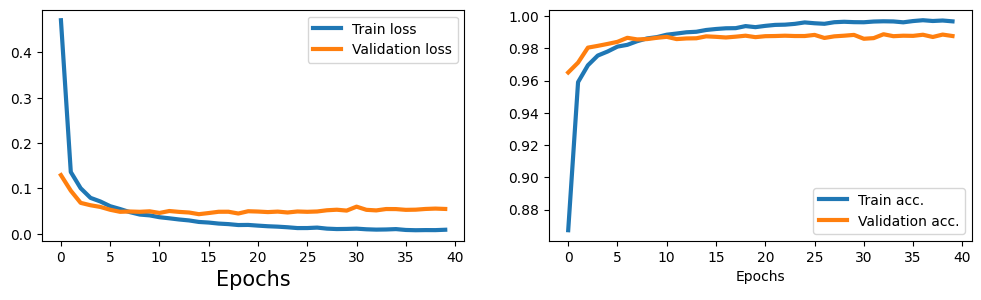

In [10]:
plot_history(history)

In [35]:
model_cpu = model.cpu()
pred = model_cpu(_test.data.unsqueeze(1) / 255.)
is_correct = (torch.argmax(pred, dim=1) == _test.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}')
print(pred.shape)

Test accuracy: 0.9900
torch.Size([10000, 10])


In [36]:
test_data_transformed = torch.stack([ x for x,y in _test])

model_cpu = model.cpu()
pred = model_cpu(test_data_transformed)
is_correct = (torch.argmax(pred, dim=1) == _test.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}')
print(pred.shape)

Test accuracy: 0.9900
torch.Size([10000, 10])


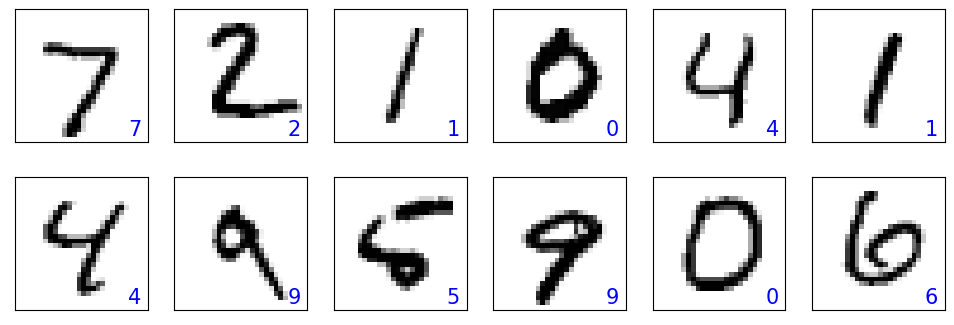

In [48]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = _test[i][0][0, :, :]
    pred = model(img.unsqueeze(0).unsqueeze(1))
    y_pred = torch.argmax(pred)
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, y_pred.item(),
    size=15, color='blue',
    horizontalalignment='center',
    verticalalignment='center',
    transform=ax.transAxes)
plt.show()